In [19]:
import warnings

warnings.filterwarnings("ignore")

from random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D,
    BatchNormalization,
    Input,
    Conv2DTranspose,
    Concatenate,
    Dropout,
    AveragePooling2D,
    UpSampling2D,
    Activation,
    ReLU,
)
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.losses import SparseCategoricalCrossentropy

In [2]:
data_dir = "./data/"
sub_folder = os.listdir(data_dir)
target_size = (256, 256)

In [3]:
def plot_subdata(dataset, subfolders):
    for folder in subfolders:
        imgfolder_path = os.path.join(dataset, folder, "CameraRGB")
        maskfolder_path = os.path.join(dataset, folder, "CameraSeg")

        img_files = os.listdir(imgfolder_path)
        mask_files = os.listdir(maskfolder_path)

        for i in range(3):
            random_num = randint(0, 1000)
            img_path = os.path.join(imgfolder_path, img_files[random_num])
            mask_path = os.path.join(maskfolder_path, mask_files[random_num])

            img = tf.io.read_file(img_path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=3)
            mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Image {i+1} - Subfolder: {folder}")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(mask)
            plt.title(f"Mask {i+1} - Subfolder: {folder}")
            plt.axis("off")

            plt.show()

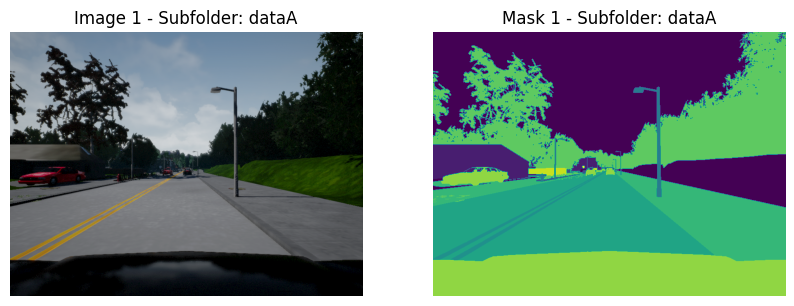

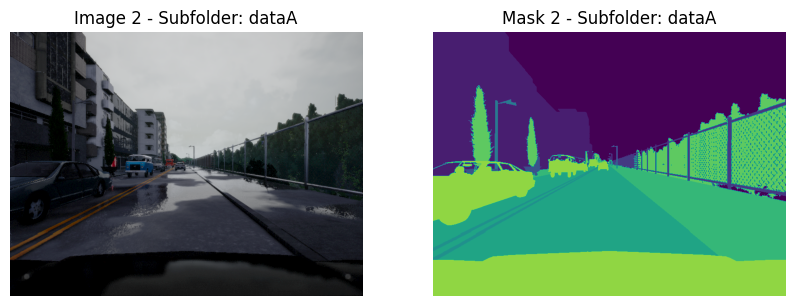

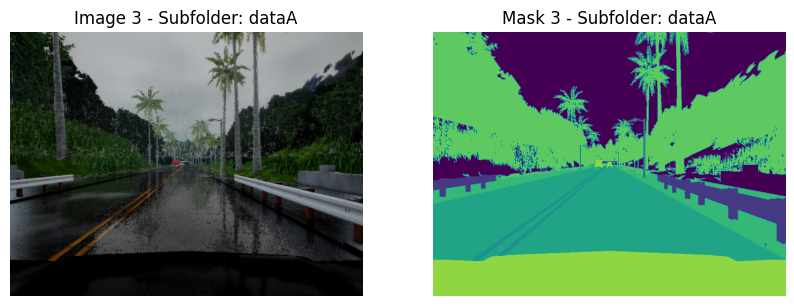

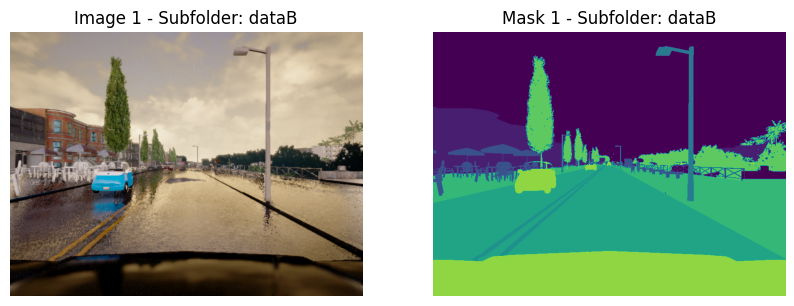

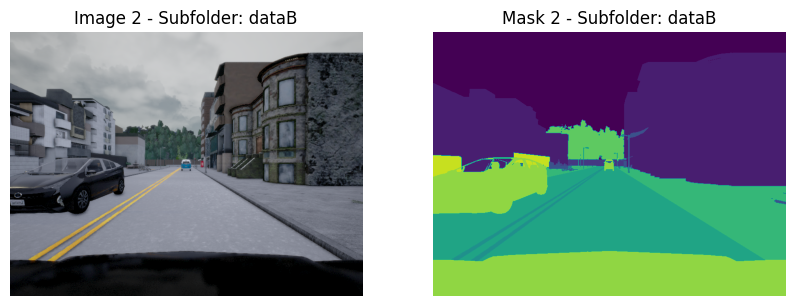

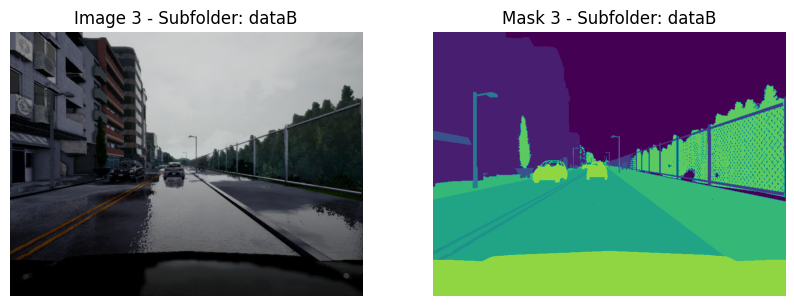

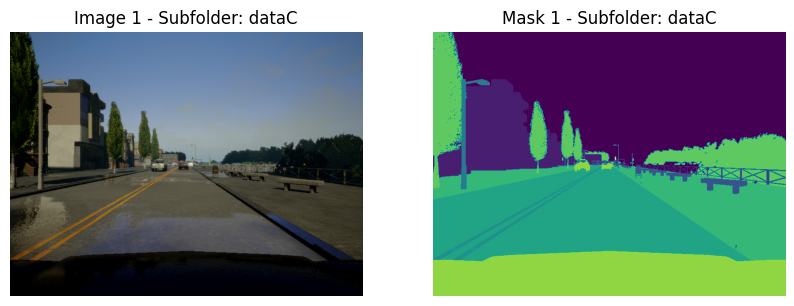

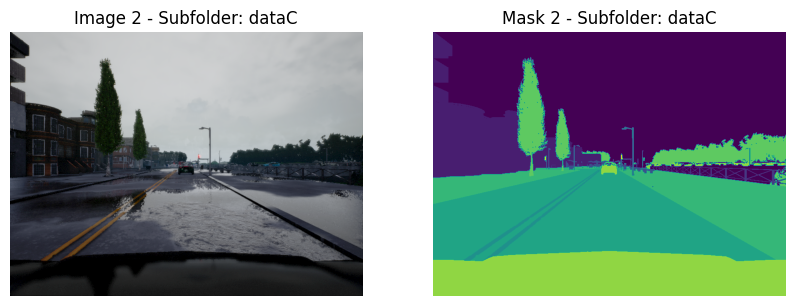

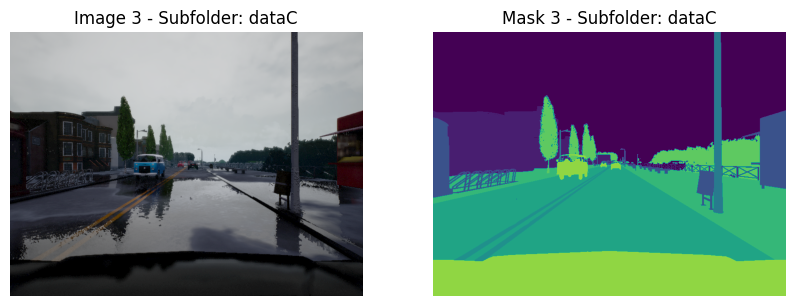

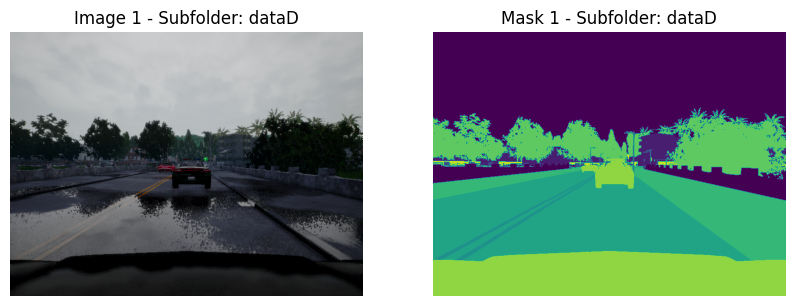

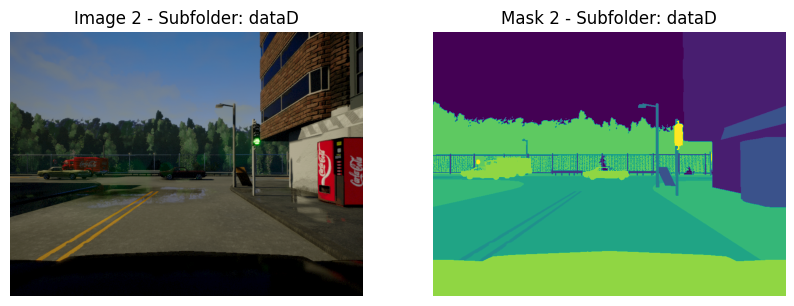

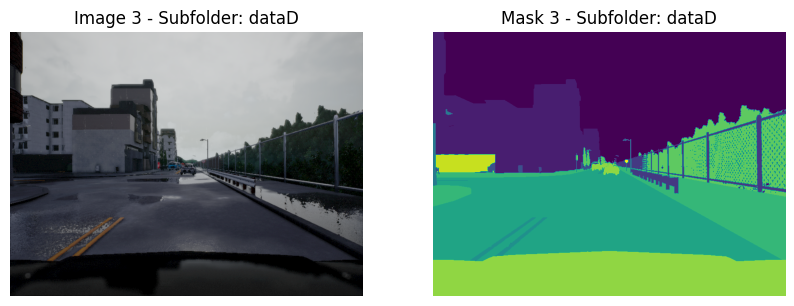

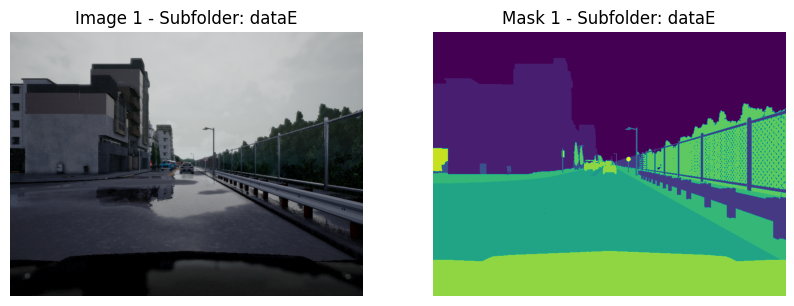

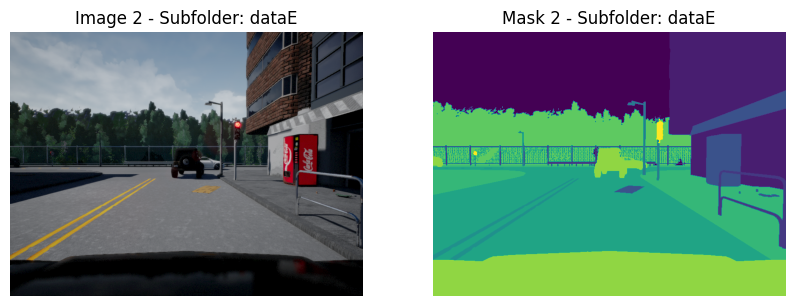

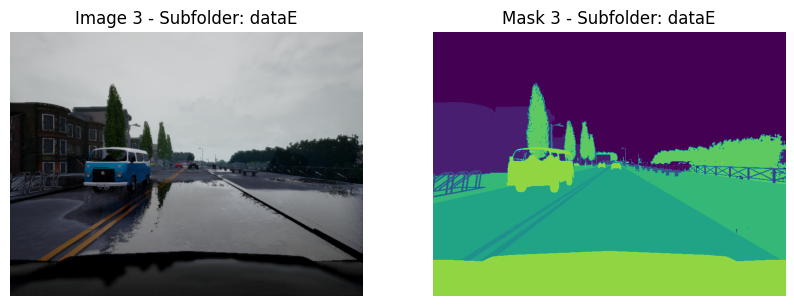

In [4]:
plot_subdata(data_dir, sub_folder)

In [5]:
images_path = []
masks_path = []

In [6]:
for folder in sub_folder:
    imgfolder_path = os.path.join(data_dir, folder, "CameraRGB")
    maskfolder_path = os.path.join(data_dir, folder, "CameraSeg")
    img_files = os.listdir(imgfolder_path)
    mask_files = os.listdir(maskfolder_path)

    for img_file, mask_file in tqdm(zip(img_files, mask_files)):
        img_path = os.path.join(imgfolder_path, img_file)
        mask_path = os.path.join(maskfolder_path, mask_file)
        images_path.append(img_path)
        masks_path.append(mask_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
image_list_ds = tf.data.Dataset.list_files(images_path, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(masks_path, shuffle=False)

full_ds = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

In [8]:
def preprocess(image, mask=None):
    input_image = tf.image.resize(image, target_size, method="nearest")
    input_mask = None
    if mask != None:
        input_mask = tf.image.resize(mask, target_size, method="nearest")

    return input_image, input_mask


def process_path(image_path, mask_path=None):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    mask = None
    if mask_path != None:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=3)
        mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    img, mask = preprocess(img, mask)

    return img, mask

In [9]:
image_ds = full_ds.map(process_path)

In [10]:
uniques = set()

for img, mask in image_ds.take(len(image_ds)):
    uniques.update(np.unique(mask.numpy()))
CLASSES = len(uniques)

In [11]:
train_size = 0.8
val_size = 0.2

train_size = int(len(image_ds) * train_size)
val_size = int(len(image_ds) * val_size)

In [12]:
image_ds = image_ds.shuffle(len(image_ds))

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)

print(
    f"Train size: {tf.data.experimental.cardinality(train_ds).numpy()} \nVal size: {tf.data.experimental.cardinality(val_ds).numpy()}"
)

Train size: 4000 
Val size: 1000


In [13]:
train_ds_b = (
    train_ds.cache()
    .batch(64)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
val_ds_b = (
    val_ds.cache()
    .batch(64)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## U-Net


U-Net is a convolutional neural network (CNN) architecture designed for semantic segmentation tasks in image processing. It was proposed by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015. The architecture is named "U-Net" due to its U-shaped structure, which consists of a contracting path to capture context and a symmetric expanding path for precise localization.

Key features of U-Net include skip connections that concatenate feature maps from the contracting path to the corresponding layer in the expanding path. These connections help preserve spatial information and improve the model's ability to localize objects accurately. U-Net has been widely used in medical image analysis, such as in segmentation of organs and structures from medical scans, but its versatility has led to applications in various image segmentation tasks.


Downsample Function:<br>
- Reduces spatial dimensions using two consecutive convolutional layers with specified filters and kernel size.<br>
- Optional batch normalization for enhanced performance.<br>
- First convolutional layer employs a specified stride for downsampling.<br>
- ReLU activation applied after each convolution.<br>
- Crucial in U-Net's contracting path, capturing high-level context information.<br>

Upsample Function:<br>
- Increases spatial dimensions through transposed convolutional layer (Conv2DTranspose).<br>
- Batch normalization and ReLU activation enhance feature representation.<br>
- Additional standard convolutional layer refines features.<br>
- Optional dropout regularization and extra batch normalization for improved generalization.<br>
- Plays a vital role in U-Net's expanding path, facilitating precise object localization in segmentation tasks.

In [15]:
def downsample(filters, size, strides=(2, 2), apply_norm=True, name=None):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = Sequential(name=name)
    result.add(
        Conv2D(
            filters,
            size,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
            strides=strides,
        )
    )

    result.add(ReLU())

    result.add(
        Conv2D(
            filters,
            size,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_norm:
        result.add(BatchNormalization())

    result.add(ReLU())

    return result


def upsample(filters, size, strides=(2, 2), apply_dropout=False, name=None):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = Sequential(name=name)
    result.add(
        Conv2DTranspose(
            filters,
            size,
            strides=strides,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(BatchNormalization())

    result.add(ReLU())

    result.add(
        Conv2D(
            filters,
            size,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(BatchNormalization())

    result.add(ReLU())

    return result

#### Main Model Overview:

##### Encoder Stack:
- Utilizes a series of downsample operations to progressively reduce spatial dimensions and capture high-level features.
- `start_filters` defines the base number of filters.
- **Layers in the encoder stack:** 
  - `encoder_1` with `start_filters` filters and a kernel size of 4.
  - `encoder_2` with `start_filters * 2` filters and a kernel size of 4.
  - `encoder_3` with `start_filters * 4` filters and a kernel size of 4.
  - `encoder_4` with `start_filters * 8` filters and a kernel size of 4.
  - `encoder_5` with `start_filters * 16` filters and a kernel size of 4.

##### Decoder Stack:
- Employs upsample operations to restore spatial dimensions and facilitate precise localization.
- `start_filters * 8` in the first decoder layer and progressively reduced in subsequent layers.
- Each decoder layer includes optional dropout for regularization.
- **Layers in the decoder stack:**
  - `decoder_1` with `start_filters * 8` filters and a kernel size of 4.
  - `decoder_2` with `start_filters * 4` filters and a kernel size of 4.
  - `decoder_3` with `start_filters * 2` filters and a kernel size of 4.
  - `decoder_4` with `start_filters` filters and a kernel size of 4.

##### Model Architecture:
- Input shape is `[256, 256, 3]`.
- Concatenates skip connections from the encoder to the corresponding layers in the decoder for enhanced information flow.
- **Final layer:**
  - Transposed convolution with 32 filters, a kernel size of 4, and strides of 2, using ReLU activation and he_normal initialization.
  - 1x1 convolution with `CLASSES` output filters for actual class prediction.


In [16]:
start_filters = 64


down_stack = [
    downsample(start_filters, 4, apply_norm=False, name="encoder_1"),
    downsample(start_filters * 2, 4, name="encoder_2"),
    downsample(start_filters * 4, 4, name="encoder_3"),
    downsample(start_filters * 8, 4, name="encoder_4"),
    downsample(start_filters * 16, 4, name="encoder_5"),
]

up_stack = [
    upsample(start_filters * 8, 4, apply_dropout=True, name="decoder_1"),
    upsample(start_filters * 4, 4, apply_dropout=True, name="decoder_2"),
    upsample(start_filters * 2, 4, apply_dropout=True, name="decoder_3"),
    upsample(start_filters, 4, apply_dropout=True, name="decoder_4"),
]

initializer = tf.random_normal_initializer(0.0, 0.02)

_input = Input(shape=[256, 256] + [3])

skips = []

x = _input

for down in down_stack:
    x = down(x)
    skips.append(x)

skips = reversed(skips[:-1])

for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate(axis=3)([x, skip])

last = Conv2DTranspose(
    32,
    4,
    strides=2,
    activation="relu",
    padding="same",
    kernel_initializer="he_normal",
)(x)

# last layer, a 2d convolution that outputs actual class prediction
last = Conv2D(CLASSES, 1, strides=1, padding="same")(last)

x = last

model = Model(inputs=_input, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder_1 (Sequential)      (None, 128, 128, 64)         68608     ['input_1[0][0]']             
                                                                                                  
 encoder_2 (Sequential)      (None, 64, 64, 128)          393728    ['encoder_1[0][0]']           
                                                                                                  
 encoder_3 (Sequential)      (None, 32, 32, 256)          1573888   ['encoder_2[0][0]']           
                                                                                              

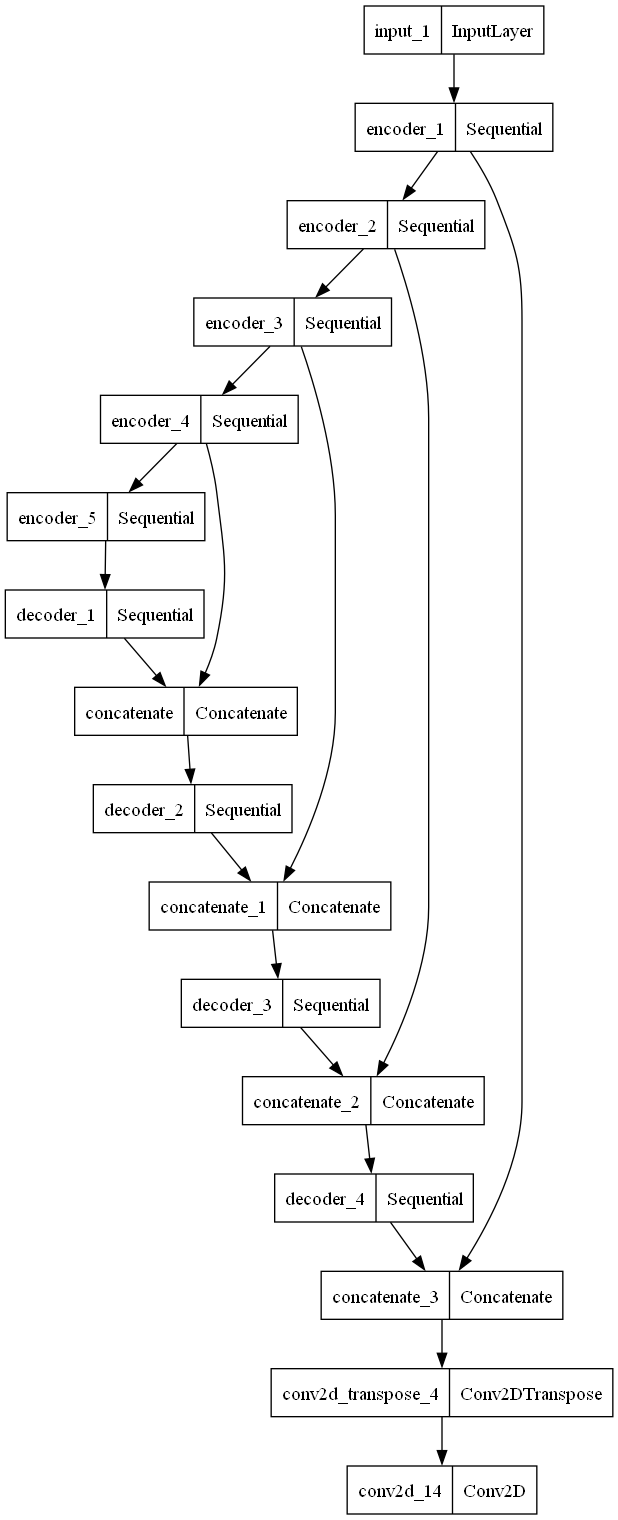

In [17]:
tf.keras.utils.plot_model(model)

In [18]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [19]:
model_hist = model.fit(train_ds_b, validation_data=(val_ds_b), epochs=10)

Epoch 1/10
125/125 [==============================] - 1493s 12s/step - loss: 0.7703 - accuracy: 0.7568 - val_loss: 1.5207 - val_accuracy: 0.7604
Epoch 2/10
125/125 [==============================] - 1439s 12s/step - loss: 0.3368 - accuracy: 0.8990 - val_loss: 0.7014 - val_accuracy: 0.8200
Epoch 3/10
125/125 [==============================] - 1422s 11s/step - loss: 0.2496 - accuracy: 0.9228 - val_loss: 0.9086 - val_accuracy: 0.7590
Epoch 4/10
125/125 [==============================] - 1441s 12s/step - loss: 0.1972 - accuracy: 0.9378 - val_loss: 0.6313 - val_accuracy: 0.8028
Epoch 5/10
125/125 [==============================] - 1459s 12s/step - loss: 0.1655 - accuracy: 0.9469 - val_loss: 0.4249 - val_accuracy: 0.8569
Epoch 6/10
125/125 [==============================] - 1454s 12s/step - loss: 0.1427 - accuracy: 0.9537 - val_loss: 0.2611 - val_accuracy: 0.9115
Epoch 7/10
125/125 [==============================] - 1408s 11s/step - loss: 0.1252 - accuracy: 0.9588 - val_loss: 0.1881 - val_ac

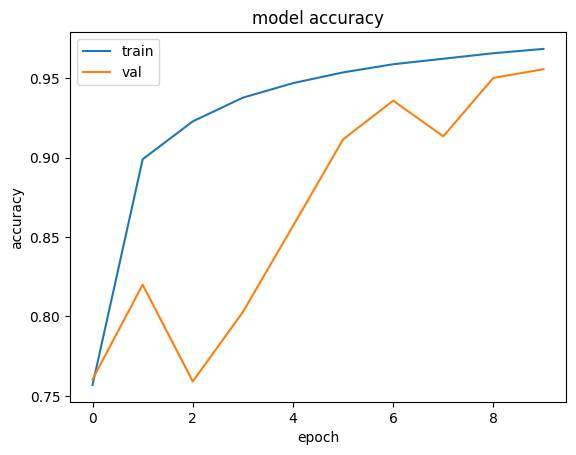

In [23]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

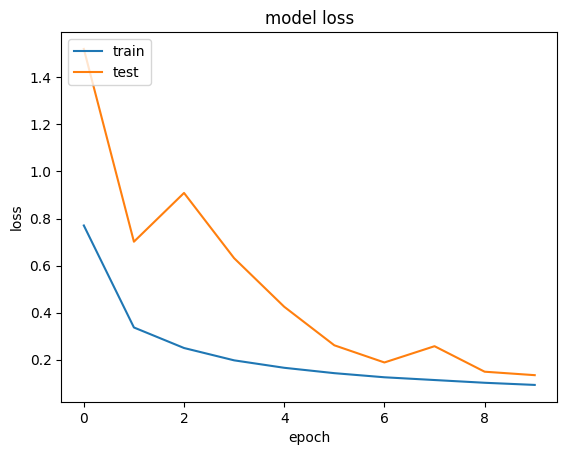

In [24]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.save("model.h5")

In [27]:
test_img_dir = "./carla-capture-20180513A/CameraRGB/"
test_mask_dir = "./carla-capture-20180513A/CameraSeg/"

In [28]:
def create_mask(pred):
    mask = tf.argmax(pred, axis=-1)
    mask = np.array(mask[..., tf.newaxis])
    return mask

In [31]:
def predict_pipline(images_path, selected_model, masks_path=None):
    image, mask = process_path(images_path, masks_path)
    image = np.array(image)
    image = image.reshape(1, 256, 256, 3)
    pred = selected_model.predict(image)
    preds = [create_mask(p) for p in pred]
    return image[0], mask, preds[0]

In [30]:
test_list = list(zip(os.listdir(test_img_dir), os.listdir(test_mask_dir)))
shuffle(test_list)

1/1 [==============================] - 0s 124ms/step


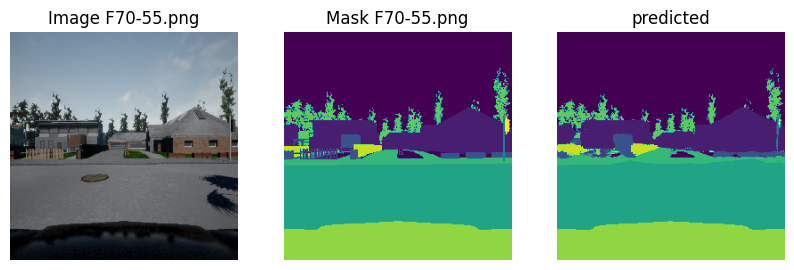

1/1 [==============================] - 0s 120ms/step


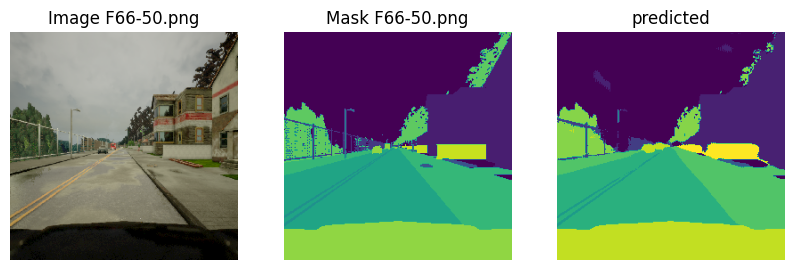

1/1 [==============================] - 0s 123ms/step


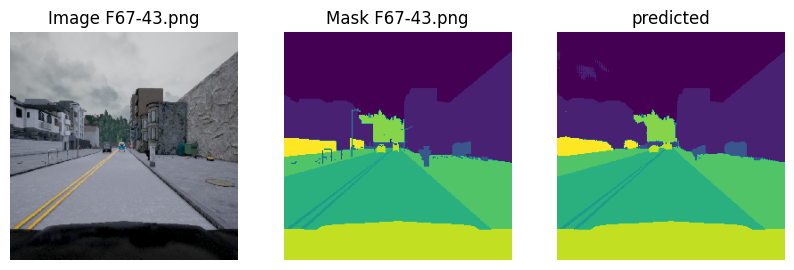

1/1 [==============================] - 0s 123ms/step


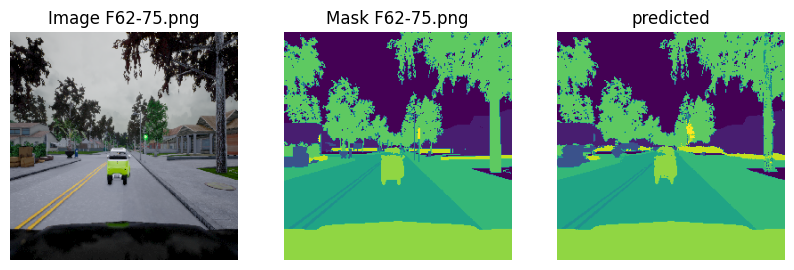

1/1 [==============================] - 0s 124ms/step


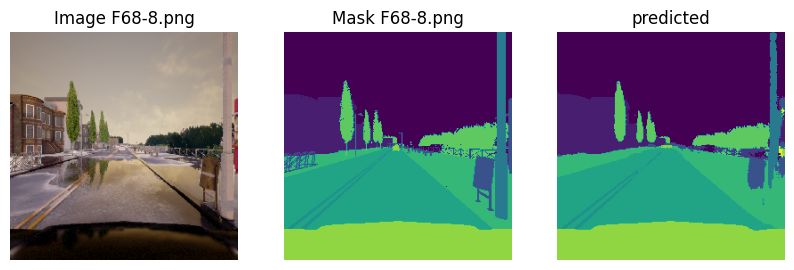

1/1 [==============================] - 0s 120ms/step


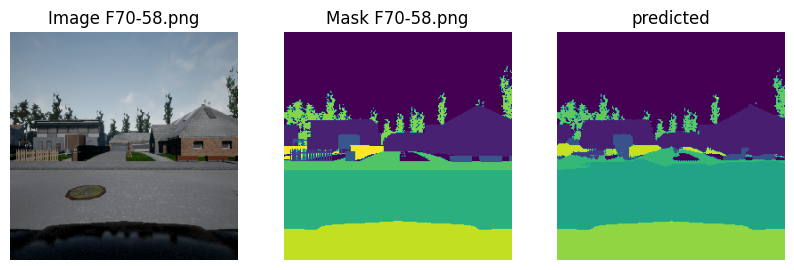

1/1 [==============================] - 0s 129ms/step


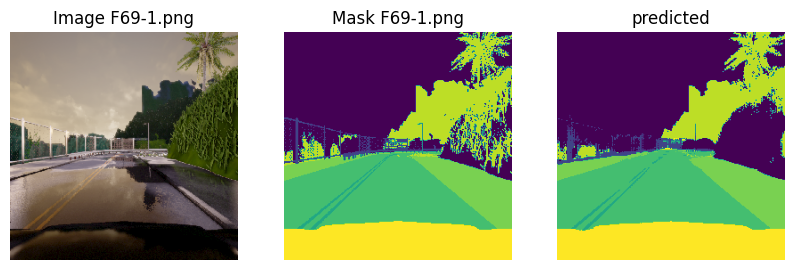

1/1 [==============================] - 0s 125ms/step


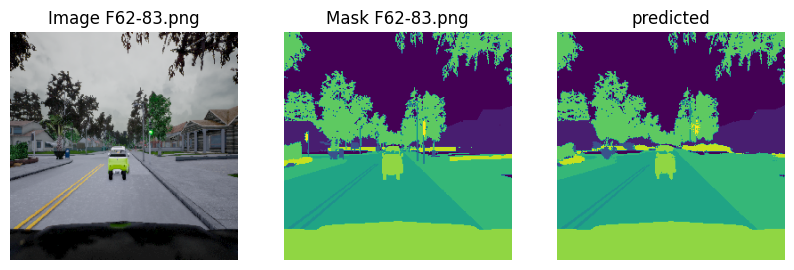

1/1 [==============================] - 0s 122ms/step


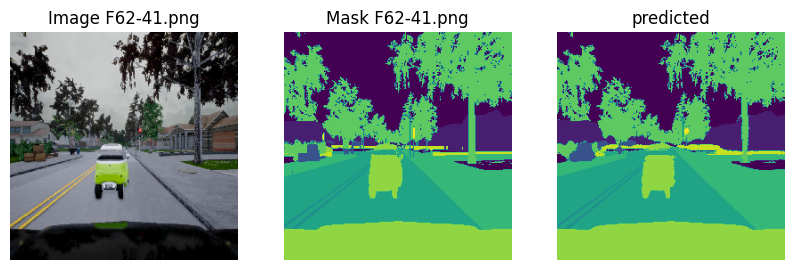

1/1 [==============================] - 0s 122ms/step


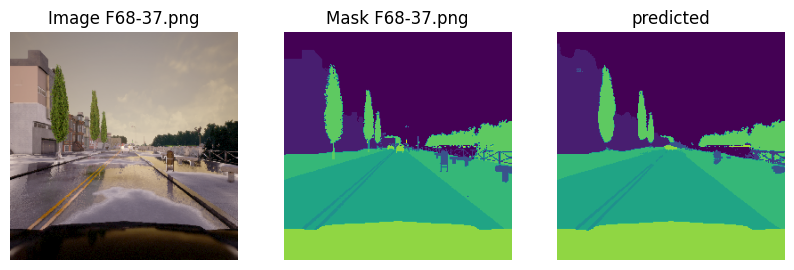

In [71]:
for test_img_path, test_mask_path in test_list[:10]:
    img_pth = os.path.join(test_img_dir, test_img_path)
    mask_pth = os.path.join(test_mask_dir, test_mask_path)
    test_img, test_mask, pred_mask = predict_pipline(img_pth, model, mask_pth)
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img)
    plt.title(f"Image {test_img_path}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(test_mask)
    plt.title(f"Mask {test_mask_path}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title(f"predicted")
    plt.axis("off")
    plt.show()

# DeepLabV3+

#### Model Architecture Overview:

##### Convolution Block Function:
- Defines a convolution block with options for the number of filters, kernel size, and dilation rate.
- Consists of Conv2D layer, BatchNormalization, and ReLU activation.

##### Dilated Spatial Pyramid Pooling (DSPP) Function:
- Takes an input and performs AveragePooling followed by convolution blocks with various dilation rates.
- Utilizes bilinear upsampling for the average-pooled result.
- Concatenates results from different dilation rates and applies a final convolution block.

##### DeeplabV3Plus Function:
- Input shape is (image_size, image_size, 3).
- Utilizes a pre-trained ResNet50 model with weights from ImageNet, freezing the layers.
- Extracts features from the "conv4_block6_2_relu" layer.
- Applies Dilated Spatial Pyramid Pooling (DSPP) to capture multi-scale context.
- Upsamples and concatenates features from DSPP with features from "conv2_block3_2_relu."
- Performs additional convolution and upsampling operations.
- Final layer is a 1x1 convolution with the specified number of output classes.

In [20]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
    )(block_input)
    x = BatchNormalization()(x)
    return Activation("relu")(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12])
    output = convolution_block(x, kernel_size=1)
    return output

In [23]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = Input(shape=(image_size, image_size, 3))
    preprocessed = preprocess_input(model_input)
    resnet50 = ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    resnet50.trainable = False
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return Model(inputs=model_input, outputs=model_output)


model_deepLabV3 = DeeplabV3Plus(image_size=target_size[0], num_classes=CLASSES)
model_deepLabV3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 256, 256, 3)          0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_2 (TFOpLamb  (None, 256, 256, 3)          0         ['tf.__operators__.getitem_2[0
 da)                                                                ][0]']                        
                                                                                            

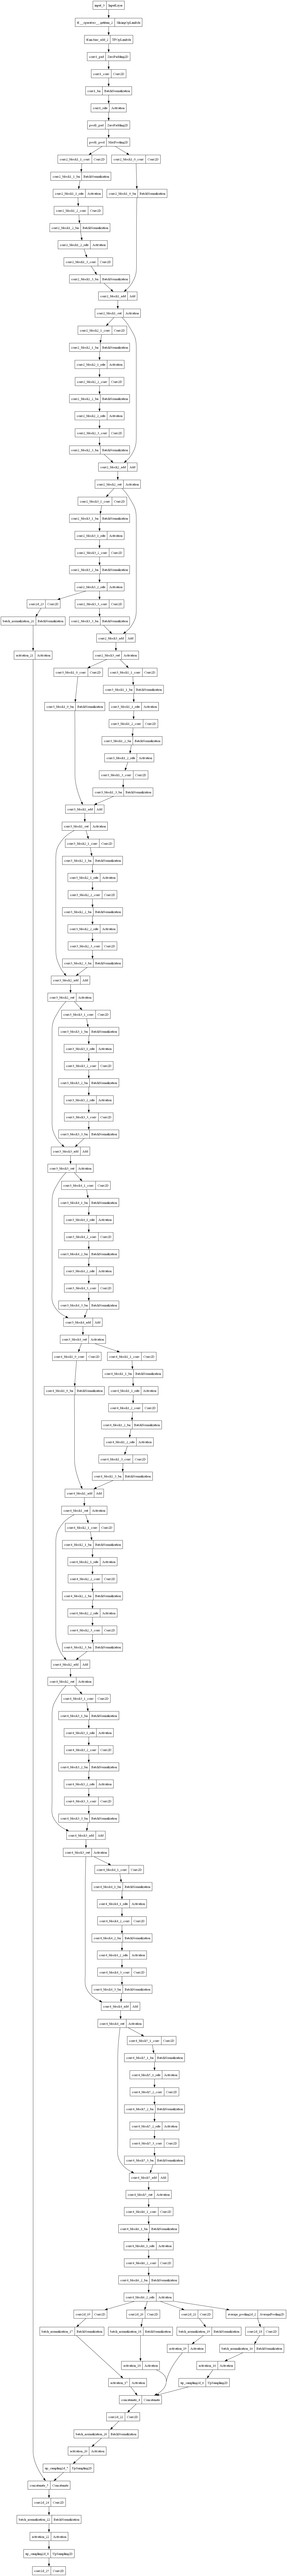

In [24]:
tf.keras.utils.plot_model(model_deepLabV3)

In [25]:
model_deepLabV3.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [36]:
deepLabV3_hist = model_deepLabV3.fit(
    train_ds_b, validation_data=val_ds_b, epochs=5, batch_size=64
)

Epoch 1/5


63/63 [==============================] - 1112s 18s/step - loss: 0.2457 - accuracy: 0.9128 - val_loss: 0.8744 - val_accuracy: 0.7317
Epoch 2/5
63/63 [==============================] - 1114s 18s/step - loss: 0.2333 - accuracy: 0.9167 - val_loss: 0.8447 - val_accuracy: 0.7600
Epoch 3/5
63/63 [==============================] - 1088s 17s/step - loss: 0.2235 - accuracy: 0.9197 - val_loss: 0.9724 - val_accuracy: 0.7523
Epoch 4/5
63/63 [==============================] - 1088s 17s/step - loss: 0.2150 - accuracy: 0.9225 - val_loss: 1.0923 - val_accuracy: 0.7352
Epoch 5/5
63/63 [==============================] - 1084s 17s/step - loss: 0.2081 - accuracy: 0.9246 - val_loss: 1.1510 - val_accuracy: 0.7321


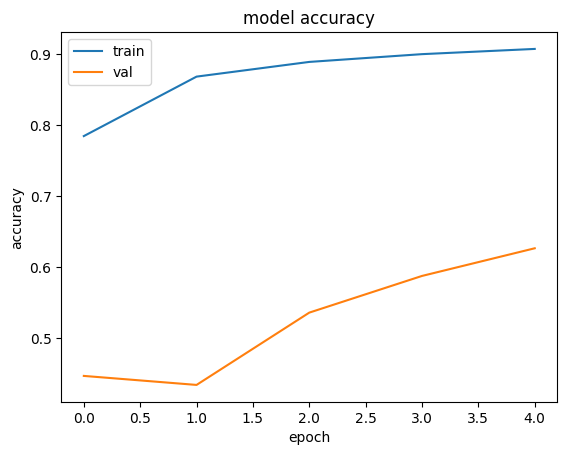

In [33]:
plt.plot(deepLabV3_hist.history['accuracy'])
plt.plot(deepLabV3_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

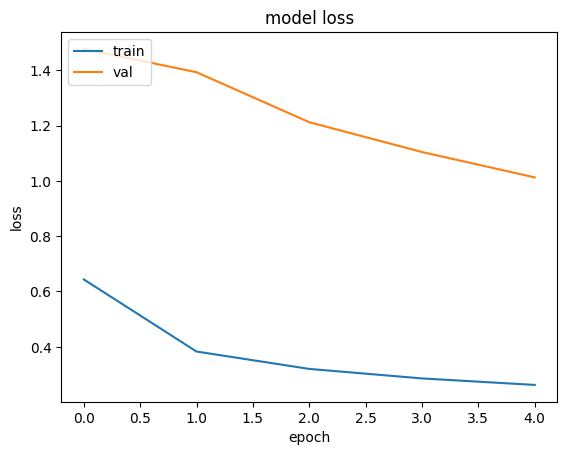

In [35]:
plt.plot(deepLabV3_hist.history['loss'])
plt.plot(deepLabV3_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step


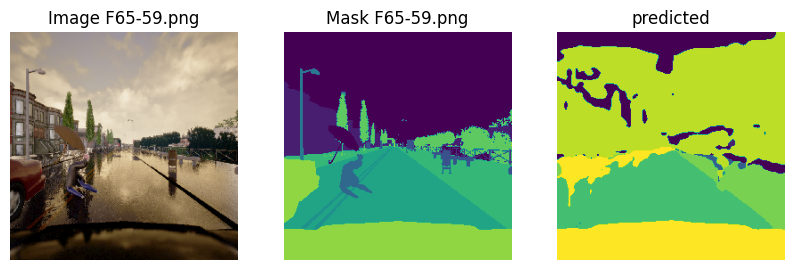

1/1 [==============================] - 0s 240ms/step


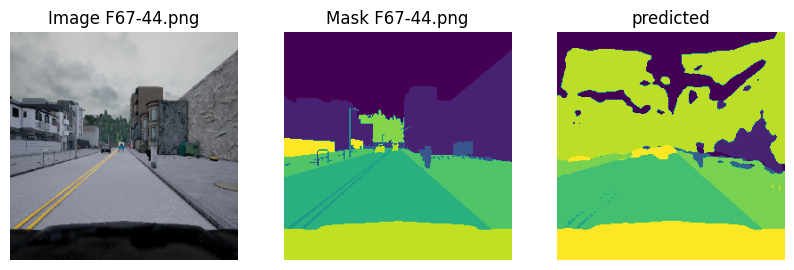

1/1 [==============================] - 0s 259ms/step


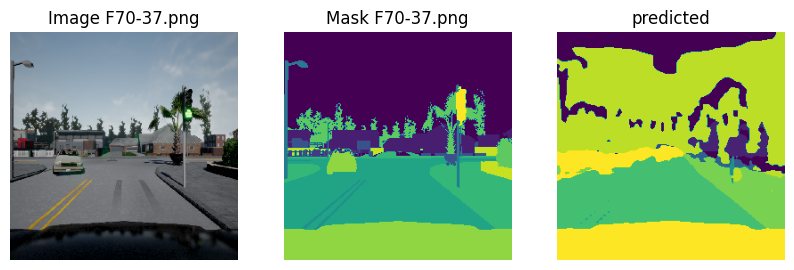

1/1 [==============================] - 0s 231ms/step


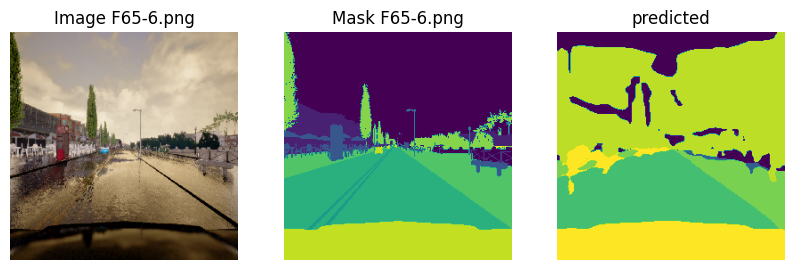

1/1 [==============================] - 0s 224ms/step


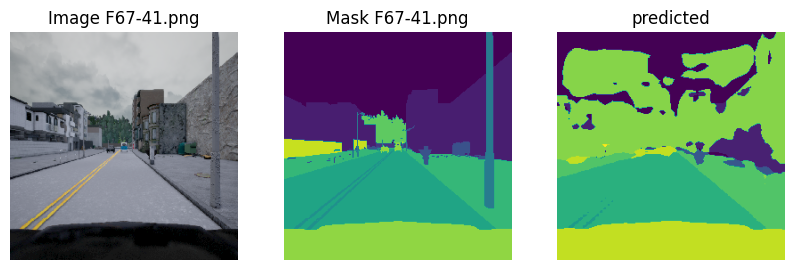

1/1 [==============================] - 0s 224ms/step


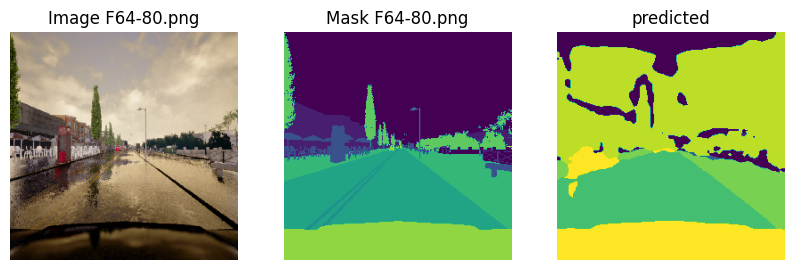

1/1 [==============================] - 0s 230ms/step


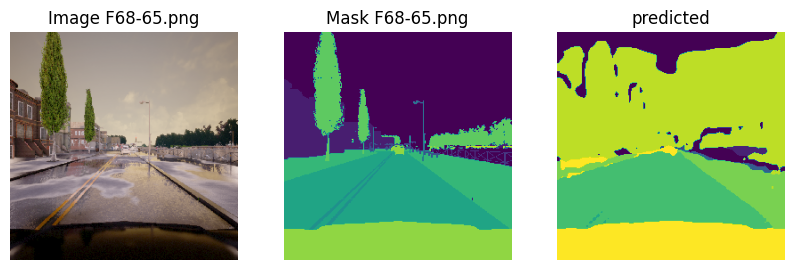

1/1 [==============================] - 0s 223ms/step


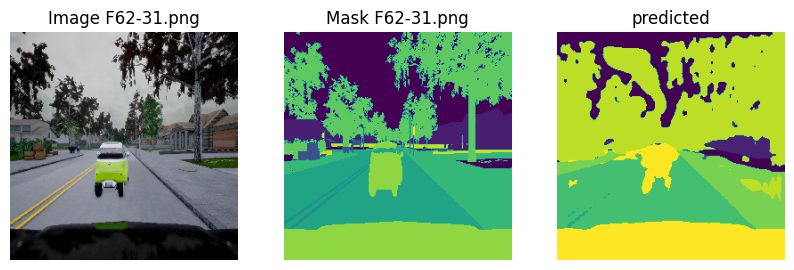

1/1 [==============================] - 0s 227ms/step


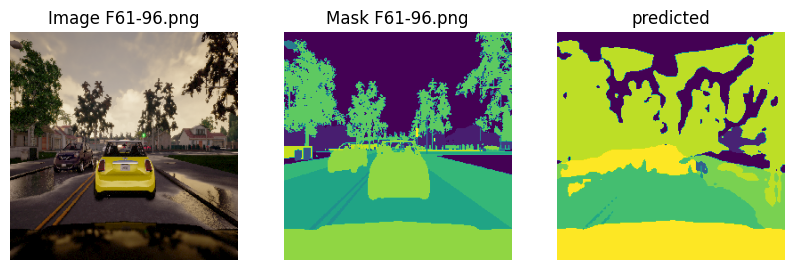

1/1 [==============================] - 0s 222ms/step


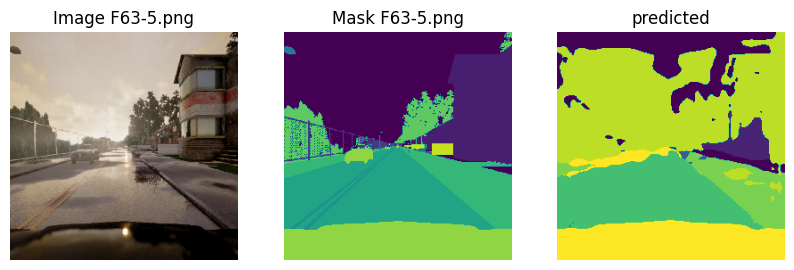

In [32]:
for test_img_path, test_mask_path in test_list[:10]:
    img_pth = os.path.join(test_img_dir, test_img_path)
    mask_pth = os.path.join(test_mask_dir, test_mask_path)
    test_img, test_mask, pred_mask = predict_pipline(
        img_pth, model_deepLabV3, mask_pth
    )
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img)
    plt.title(f"Image {test_img_path}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(test_mask)
    plt.title(f"Mask {test_mask_path}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title(f"predicted")
    plt.axis("off")
    plt.show()

For DeepLabV3, we think we should paid more time for model training, but with my limited local resource I can only do with 5 epoch

Second try:

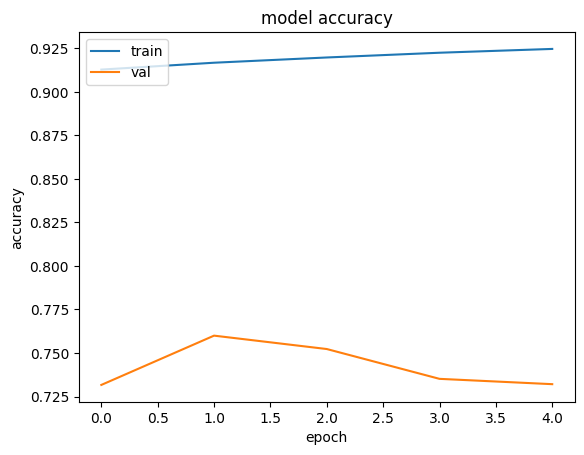

In [37]:
plt.plot(deepLabV3_hist.history['accuracy'])
plt.plot(deepLabV3_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

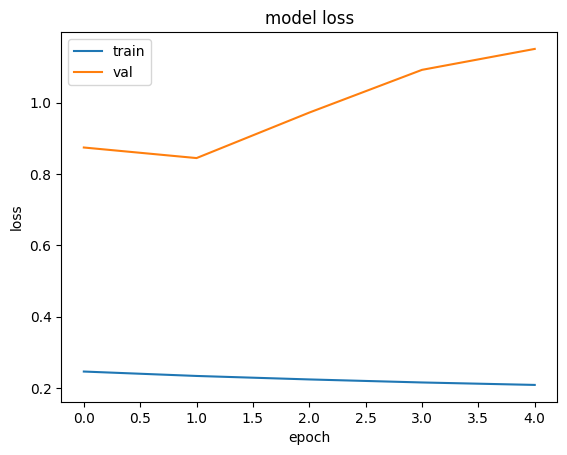

In [38]:
plt.plot(deepLabV3_hist.history['loss'])
plt.plot(deepLabV3_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 393ms/step


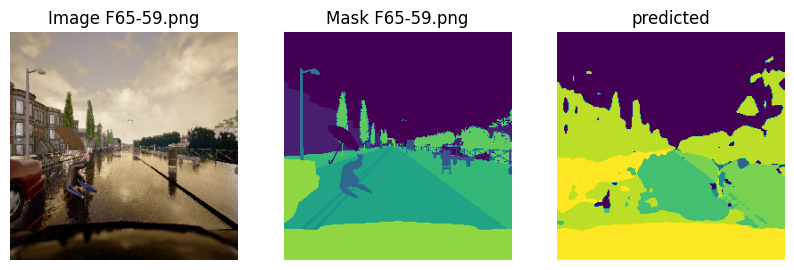

1/1 [==============================] - 0s 260ms/step


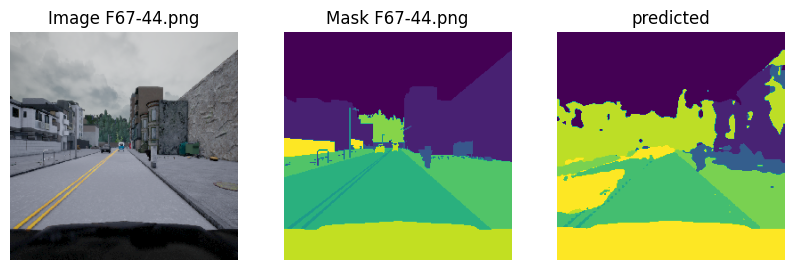

1/1 [==============================] - 0s 257ms/step


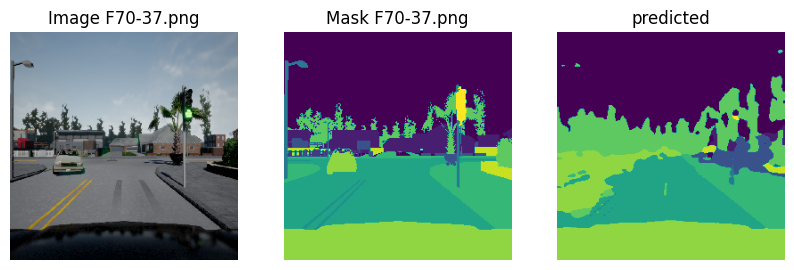

1/1 [==============================] - 0s 243ms/step


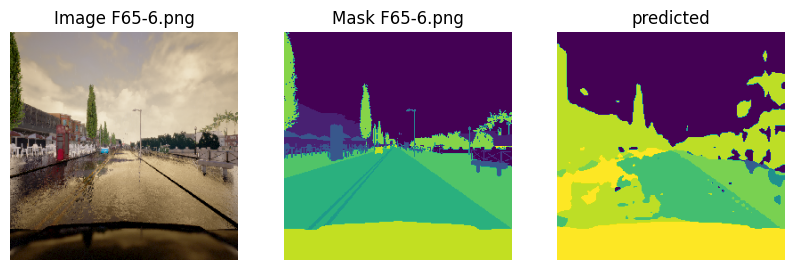

1/1 [==============================] - 0s 256ms/step


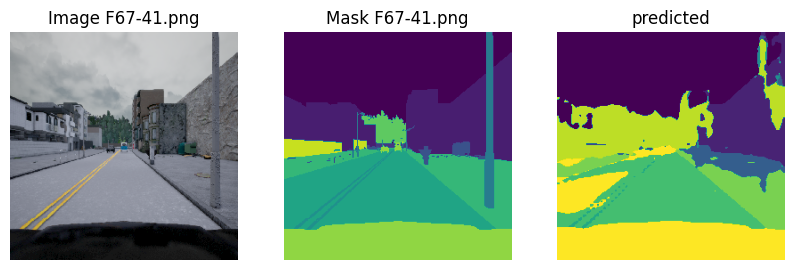

1/1 [==============================] - 0s 236ms/step


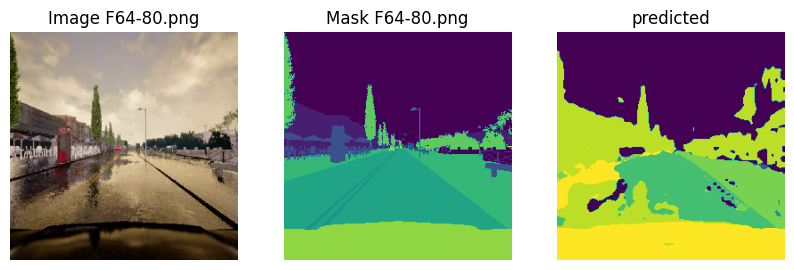

1/1 [==============================] - 0s 239ms/step


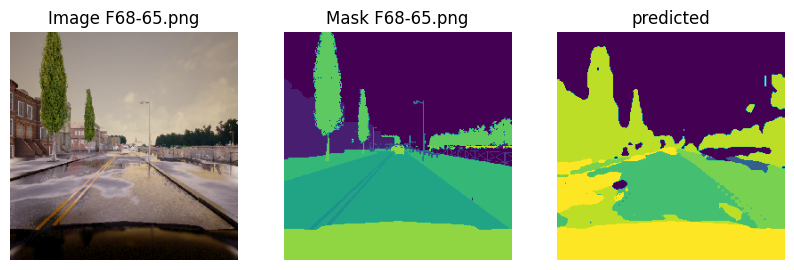

1/1 [==============================] - 0s 237ms/step


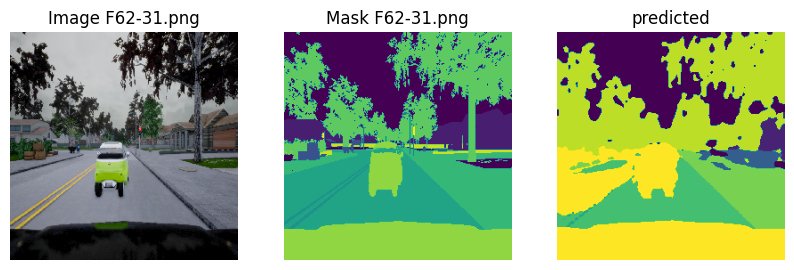

1/1 [==============================] - 0s 259ms/step


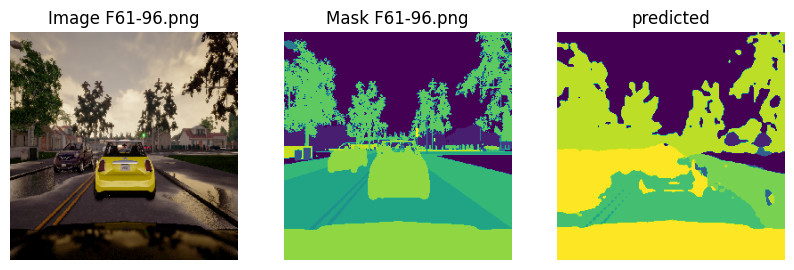

1/1 [==============================] - 0s 247ms/step


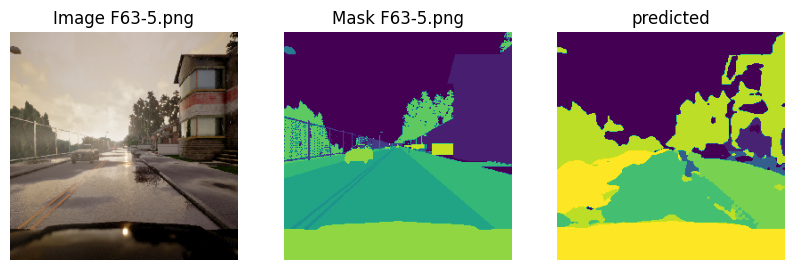

In [39]:
for test_img_path, test_mask_path in test_list[:10]:
    img_pth = os.path.join(test_img_dir, test_img_path)
    mask_pth = os.path.join(test_mask_dir, test_mask_path)
    test_img, test_mask, pred_mask = predict_pipline(
        img_pth, model_deepLabV3, mask_pth
    )
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img)
    plt.title(f"Image {test_img_path}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(test_mask)
    plt.title(f"Mask {test_mask_path}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title(f"predicted")
    plt.axis("off")
    plt.show()

In [ ]:
model_deepLabV3.save("./deepLabv3.h5")